In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
from PIL import Image, ImageDraw, ImageFont
from tensorflow import keras
from tensorflow.keras.applications import Xception
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
with open('/content/drive/My Drive/Data/resize/X_80.pkl', 'rb') as fp:
  X_80 = pickle.load(fp)

with open('/content/drive/My Drive/Data/resize/y.pkl', 'rb') as fp:
  y = pickle.load(fp)

In [4]:
y = np.array(pd.get_dummies(y))

In [5]:
def get_classes(y):
  return [list(i).index(max(i)) for i in y]

In [6]:
classes = get_classes(y)
cw = dict(enumerate(class_weight.compute_class_weight('balanced', np.unique(classes), classes)))

In [7]:
# X_80 = [np.stack((img,)*3, axis=-1) for img in X_80]

In [8]:
X_80_train, X_80_test, y_train, y_test = train_test_split(X_80, y, test_size=int(len(y)*.15), random_state=42)
X_80_train, X_80_val, y_train, y_val = train_test_split(X_80_train, y_train, test_size=int(len(y)*.15), random_state=42)

In [9]:
print(len(X_80_train))
print(len(X_80_val))
print(len(X_80_test))

478426
102519
102519


In [10]:
print(len(y_train))
print(len(y_val))
print(len(y_test))

478426
102519
102519


In [11]:
base_model = Xception(
    weights='imagenet',
    input_shape=(80,80,3),
    include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-3]:
  layer.trainable=False

In [12]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 39, 39, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 39, 39, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 39, 39, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [13]:
inputs = keras.Input(shape=(80,80,3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x) 
outputs = keras.layers.Dense(514)(x)
model = keras.Model(inputs, outputs)

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 514)               1053186   
Total params: 21,914,666
Trainable params: 4,216,834
Non-trainable params: 17,697,832
_________________________________________________________________


In [15]:
history = model.fit(
    np.array([np.stack((img,)*3, axis=-1) for img in X_80_train]), 
    np.array(y_train), 
    epochs=30, 
    batch_size=128, 
    class_weight=cw,
    validation_data=(np.array([np.stack((img,)*3, axis=-1) for img in X_80_val]), y_val))

Epoch 1/30
3738/3738 [==============================] - 116s 31ms/step - loss: 9.0330 - acc: 0.0011 - val_loss: 10.6207 - val_acc: 4.6821e-04
Epoch 2/30
3738/3738 [==============================] - 115s 31ms/step - loss: 8.5627 - acc: 5.9779e-04 - val_loss: 4.3279 - val_acc: 1.2681e-04
Epoch 3/30
3738/3738 [==============================] - 115s 31ms/step - loss: 8.6049 - acc: 3.7205e-04 - val_loss: 5.9846 - val_acc: 4.3894e-04
Epoch 4/30
3738/3738 [==============================] - 115s 31ms/step - loss: 8.5750 - acc: 4.7865e-04 - val_loss: 12.3200 - val_acc: 1.2681e-04
Epoch 5/30
3738/3738 [==============================] - 114s 31ms/step - loss: 8.6646 - acc: 5.4763e-04 - val_loss: 8.0824 - val_acc: 1.2681e-04
Epoch 6/30
3738/3738 [==============================] - 114s 31ms/step - loss: 8.6911 - acc: 4.1177e-04 - val_loss: 3.8744 - val_acc: 5.1698e-04
Epoch 7/30
3738/3738 [==============================] - 114s 31ms/step - loss: 8.7651 - acc: 4.4103e-04 - val_loss: 4.0833 - val_acc

In [16]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

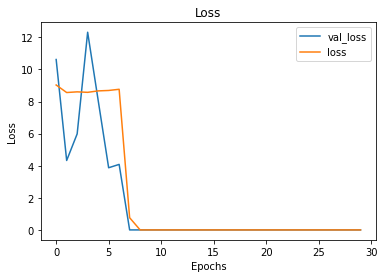

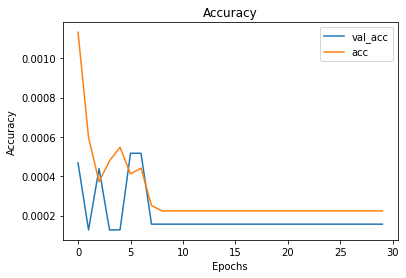

In [17]:
visualize_training_results(history)